In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
! ls

gdrive	sample_data


In [3]:
%cd gdrive/My Drive/ACGAN-MNIST

/content/gdrive/My Drive/ACGAN-MNIST


In [4]:
import torch
import random
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt 
from torchvision.utils import make_grid
from discriminator import Discriminator
from generator import Generator
import torchvision.transforms as transforms
import torch.nn.functional as F 
import torch.utils.data
import torchvision
import numpy as np
from torch.autograd import Variable

In [5]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
#HyperParameters
Batch_size=100
lr=0.0002
epochs=10

In [7]:
'''
Data_preprocessing:
1 : Resizing the Image 
2 : Convert the Image to Torch Tensor
3 : Normalize the Pixel value with additional Noise
'''
Data_transform=transforms.Compose([ transforms.Resize(64),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=(0.1307,),std=(0.3081,))])

In [8]:
trainset=torchvision.datasets.MNIST(root='../data',train=True,download=True,transform=Data_transform)
trainloader=DataLoader(trainset,batch_size=Batch_size,num_workers=2,shuffle=True)

In [9]:
#Weight Initialization 
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [10]:
#Utlitiy Function to Show the Generated Output
def showimage(images):
    image=images.cpu().numpy()
    image=image/2+0.5
    plt.imshow(np.transpose(images, axes=(1, 2, 0)))
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 1, 64, 64])


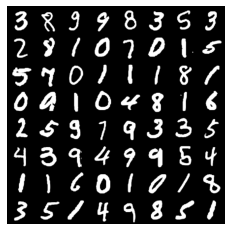

In [11]:
#Sample input Images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.size())
showimage(make_grid(images[0:64]))

In [12]:
#Initializing Generator and Discriminator
generator=Generator().to(device)
generator.apply(weights_init)
discriminator=Discriminator().to(device)
discriminator.apply(weights_init)

gen_params=list(generator.parameters())
print(len(gen_params))

disc_params=list(discriminator.parameters())
print(len(disc_params))


14
12


In [13]:
#LOSS
adversarial_loss=nn.BCELoss().cuda()
auxiliary_loss=nn.CrossEntropyLoss().cuda()

# Optimizer
optimG = optim.Adam(generator.parameters(), lr, betas=(0.5, 0.999))
optimD = optim.Adam(discriminator.parameters(), lr, betas=(0.5, 0.999))


In [14]:
#Label Smoothening
real_labels = 0.7 + 0.5 * torch.rand(10, device=device)  
fake_labels = 0.3 * torch.rand(10, device=device)

In [15]:
''' Function :train_generator
 -----To train the Generator Network-----
'''
def train_generator(batch_size,generator,discriminator):
    optimG.zero_grad()
    #generate Noise Samples and Randorm Labels from Latent Space
    z = torch.randn(batch_size, 100, device=device)
    gen_labels = torch.randint(0, 10, (batch_size,), device=device, dtype=torch.long)
    #Generate Image with Noise and Labels
    gen_imgs = generator(z, gen_labels)

    #Image Generated is passed into Discriminator so as to Fool Discriminator and Loss is computed
    validity, pred_label = discriminator(gen_imgs)
    g_loss = 0.5 * (adversarial_loss(validity, Variable(torch.ones(batch_size,device=device))) + auxiliary_loss(pred_label, gen_labels))
    
    D_G_z2 = validity.mean().item()
    #Backprop and Weight Update
    g_loss.backward()
    optimG.step()
    return g_loss.item(),D_G_z2

In [16]:
''' Function :train_discriminator
 ------To train the Discriminator Network------
'''
def train_discriminator(batch_size,generator,discriminator,real_img,label,real,fake):
    optimD.zero_grad()
    validity_label = torch.full((batch_size,), real, device=device)
    #Discriminator classifies the Real Images and Their Class Label
    real_pred, real_aux = discriminator(real_img)
    d_real_loss = (adversarial_loss(real_pred,validity_label) + auxiliary_loss(real_aux, label)) / 2
    
    D_x = real_pred.mean().item()
    d_real_loss.backward()

    #Noise and random Sample is generated for Fake Images
    z = torch.randn(batch_size, 100, device=device)
    gen_labels = torch.randint(0, 10, (batch_size,), device=device, dtype=torch.long)
    gen_imgs = generator(z, gen_labels)
    validity_label.fill_(fake)
    fake_pred, fake_aux = discriminator(gen_imgs.detach())
    
    d_fake_loss = (adversarial_loss(fake_pred,validity_label) + auxiliary_loss(fake_aux, gen_labels)) / 2

    D_G_z1 = fake_pred.mean().item()
    # Total discriminator loss
    d_loss = (d_real_loss + d_fake_loss) / 2
    d_fake_loss.backward()
    optimD.step()
    return d_loss.item(),D_x,D_G_z1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 0/10] [Batch 599/600] [D loss: 0.450958] [G loss: 0.792792]


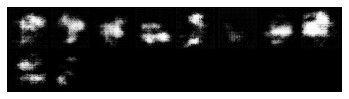

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 1/10] [Batch 599/600] [D loss: 0.409256] [G loss: 0.654149]


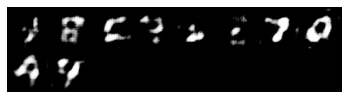

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 2/10] [Batch 599/600] [D loss: 0.336887] [G loss: 0.721551]


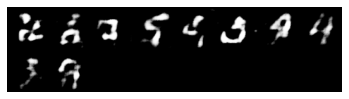

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 3/10] [Batch 599/600] [D loss: 0.325825] [G loss: 0.741746]


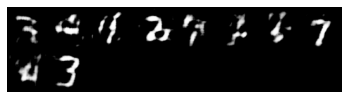

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 4/10] [Batch 599/600] [D loss: 0.285760] [G loss: 0.663852]


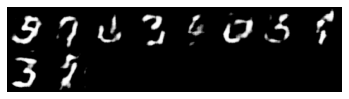

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 5/10] [Batch 599/600] [D loss: 0.251664] [G loss: 0.680760]


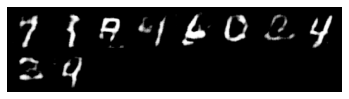

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 6/10] [Batch 599/600] [D loss: 0.257455] [G loss: 0.551482]


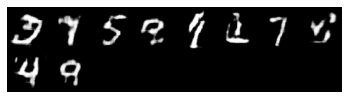

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 7/10] [Batch 599/600] [D loss: 0.241239] [G loss: 0.647087]


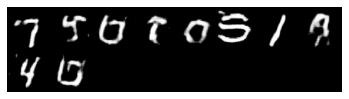

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 8/10] [Batch 599/600] [D loss: 0.221862] [G loss: 0.698559]


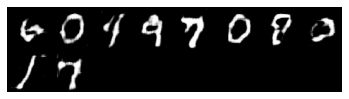

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 9/10] [Batch 599/600] [D loss: 0.225020] [G loss: 0.680771]


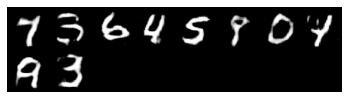

In [17]:
for epoch in range(epochs):
    for idx,(image,label) in enumerate(trainloader):
        generator.train()
        batch_size=image.size(0)
        
        image=image.to(device)
        label=label.to(device)

        real_label = real_labels[idx % 10]
        fake_label = fake_labels[idx % 10]

        # label flipping
        if idx % 7 == 0:
          real_label,fake_label=fake_label,real_label 
        
        d_loss,D_x,D_G_z1=train_discriminator(batch_size,generator,discriminator,image,label,real_label,fake_label)
        g_loss,D_G_z2=train_generator(batch_size,generator,discriminator)
    print(
          "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
          % (epoch, epochs, idx, len(trainloader), d_loss, g_loss))
    #To Generate Image after Each Epoch
    noise = torch.randn(10, 100, device=device)
    labels = torch.randint(0, 10, (10,), dtype=torch.long, device=device, )
    fakes = generator(noise, labels).detach()
    showimage(make_grid(fakes).cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


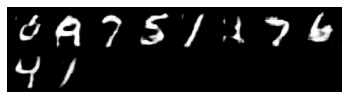

[Epoch 9/10] [Batch 599/600] [D loss: 0.225020] [G loss: 0.680771] [D(x): 0.841546] [D(G(z1)): 0.255252] [D(G(z2)): 0.272502]


In [20]:
noise = torch.randn(10, 100, device=device)
labels = torch.randint(0, 10, (10,), dtype=torch.long, device=device, )
fakes = generator(noise, labels).detach()
showimage(make_grid(fakes).cpu())

print(
          "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [D(x): %f] [D(G(z1)): %f] [D(G(z2)): %f]"
          % (epoch, epochs, idx, len(trainloader), d_loss, g_loss,D_x,D_G_z1,D_G_z2))